In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.io as io
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
model = models.resnet50(pretrained=True, progress=True)

In [3]:
# fine tune the last layer
model.fc = nn.Linear(in_features=2048, out_features=8, bias=True)

In [4]:
augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.405], std=[0.229, 0.224, 0.225])
])

In [5]:
class Data(torch.utils.data.Dataset):
    def __init__(self, augment):
        self.data = []
        self.labels = []
        self.dir = 'D:/Data/hd/train'
        self.augment = augment
        
        i = 0
        for folder in os.listdir(self.dir):
            label = i
            for file in tqdm(os.listdir(os.path.join(self.dir, folder))):
                img_path = os.path.join(os.path.join(self.dir, folder), file)
                
                # Open and apply augmentation
                img = io.read_image(img_path)
                img = self.augment(img)
                 
                # Append the image and its corresponding label to the output
                self.data.append(img)
                self.labels.append(label)
            i += 1
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [6]:
data = Data(augment)

100%|███████████████████████████████████████████████| 3210/3210 [00:49<00:00, 65.20it/s]


In [7]:
device = torch.device('cuda')

In [8]:
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

In [9]:
train, val = torch.utils.data.random_split(data, [22972, 2552])
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=32)
valloader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=32)

In [10]:
training_losses, val_losses = [], []
avg_training_losses, avg_val_losses = [], []
accuracies = []

In [11]:
for e in tqdm(range(7)):
    for x, y in trainloader:
        model.train()
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x.float())
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()
        npl = l.detach().cpu().numpy()
        training_losses.append(npl)

    acc = 0
    acc_t, acc_p = [], []
    with torch.no_grad():
        for x, y in valloader:
            model.eval()
            x, y = x.to(device), y.to(device)
            y_pred = model(x.float())
            l = loss(y_pred, y)
            npl = l.detach().cpu().numpy()
            val_losses.append(npl)
            
            # accuracy metric as well
            p = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
            tp = y.detach().cpu().numpy()
            acc_p.append(p)
            acc_t.append(tp)
    
    for x, y in zip(acc_p, acc_t):
        for i, j in zip(x, y):
            if i == j:
                acc += 1
                
    val_acc = acc / 2552
    avg_training_losses.append(np.mean(training_losses))
    avg_val_losses.append(np.mean(val_losses))
    accuracies.append(val_acc)

    print(f'Epoch: {e}, Training Loss: {np.mean(training_losses)}, Validation Loss: {np.mean(val_losses)}, Accuracy: {val_acc}')

  4%|█▉                                               | 1/25 [03:04<1:13:38, 184.10s/it]

Epoch: 0, Training Loss: 1.3199018239974976, Validation Loss: 1.0639394521713257, Accuracy: 0.6344043887147336


  8%|███▉                                             | 2/25 [06:06<1:10:15, 183.30s/it]

Epoch: 1, Training Loss: 1.1456713676452637, Validation Loss: 1.0228689908981323, Accuracy: 0.670846394984326


 12%|█████▉                                           | 3/25 [09:11<1:07:21, 183.70s/it]

Epoch: 2, Training Loss: 1.0398310422897339, Validation Loss: 0.9447796940803528, Accuracy: 0.7260971786833855


 16%|███████▊                                         | 4/25 [12:14<1:04:16, 183.64s/it]

Epoch: 3, Training Loss: 0.9592183232307434, Validation Loss: 0.9441755414009094, Accuracy: 0.6782915360501567


 20%|█████████▊                                       | 5/25 [15:18<1:01:16, 183.81s/it]

Epoch: 4, Training Loss: 0.8961654305458069, Validation Loss: 0.9001971483230591, Accuracy: 0.7594043887147336


 24%|████████████▏                                      | 6/25 [18:22<58:11, 183.78s/it]

Epoch: 5, Training Loss: 0.8426710963249207, Validation Loss: 0.8721647262573242, Accuracy: 0.7398119122257053


 28%|██████████████▎                                    | 7/25 [21:26<55:08, 183.82s/it]

Epoch: 6, Training Loss: 0.7966349720954895, Validation Loss: 0.8645821809768677, Accuracy: 0.7323667711598746


 32%|████████████████▎                                  | 8/25 [24:30<52:05, 183.86s/it]

Epoch: 7, Training Loss: 0.7556052207946777, Validation Loss: 0.852990448474884, Accuracy: 0.7496081504702194


 36%|██████████████████▎                                | 9/25 [27:34<49:04, 184.02s/it]

Epoch: 8, Training Loss: 0.7180514335632324, Validation Loss: 0.8322135210037231, Accuracy: 0.783307210031348


 40%|████████████████████                              | 10/25 [30:39<46:02, 184.16s/it]

Epoch: 9, Training Loss: 0.6834000945091248, Validation Loss: 0.8207184076309204, Accuracy: 0.7793887147335423


 44%|██████████████████████                            | 11/25 [33:43<42:58, 184.21s/it]

Epoch: 10, Training Loss: 0.649898886680603, Validation Loss: 0.8189390897750854, Accuracy: 0.7519592476489029


 48%|████████████████████████                          | 12/25 [36:47<39:56, 184.32s/it]

Epoch: 11, Training Loss: 0.6185158491134644, Validation Loss: 0.8173295259475708, Accuracy: 0.7891849529780565


 52%|██████████████████████████                        | 13/25 [39:52<36:52, 184.41s/it]

Epoch: 12, Training Loss: 0.5885476469993591, Validation Loss: 0.8203710913658142, Accuracy: 0.7648902821316614


 56%|████████████████████████████                      | 14/25 [42:57<33:49, 184.48s/it]

Epoch: 13, Training Loss: 0.5605670213699341, Validation Loss: 0.8257862329483032, Accuracy: 0.7644984326018809


 60%|██████████████████████████████                    | 15/25 [46:01<30:44, 184.44s/it]

Epoch: 14, Training Loss: 0.5347082018852234, Validation Loss: 0.8402426242828369, Accuracy: 0.7480407523510971


 64%|████████████████████████████████                  | 16/25 [49:05<27:39, 184.41s/it]

Epoch: 15, Training Loss: 0.5107452869415283, Validation Loss: 0.8515939712524414, Accuracy: 0.7503918495297806


 68%|██████████████████████████████████                | 17/25 [52:10<24:35, 184.40s/it]

Epoch: 16, Training Loss: 0.48894014954566956, Validation Loss: 0.858160138130188, Accuracy: 0.7621473354231975


 72%|████████████████████████████████████              | 18/25 [55:15<21:31, 184.56s/it]

Epoch: 17, Training Loss: 0.46871843934059143, Validation Loss: 0.868377149105072, Accuracy: 0.77076802507837


 76%|██████████████████████████████████████            | 19/25 [58:24<18:35, 185.88s/it]

Epoch: 18, Training Loss: 0.44989970326423645, Validation Loss: 0.8787474036216736, Accuracy: 0.7629310344827587


 80%|██████████████████████████████████████▍         | 20/25 [1:01:29<15:28, 185.78s/it]

Epoch: 19, Training Loss: 0.43305233120918274, Validation Loss: 0.9010122418403625, Accuracy: 0.7366771159874608


 84%|████████████████████████████████████████▎       | 21/25 [1:04:36<12:23, 185.94s/it]

Epoch: 20, Training Loss: 0.41763317584991455, Validation Loss: 0.9127012491226196, Accuracy: 0.7660658307210031


 88%|██████████████████████████████████████████▏     | 22/25 [1:07:42<09:18, 186.05s/it]

Epoch: 21, Training Loss: 0.40293917059898376, Validation Loss: 0.9256112575531006, Accuracy: 0.7413793103448276


 92%|████████████████████████████████████████████▏   | 23/25 [1:10:48<06:12, 186.03s/it]

Epoch: 22, Training Loss: 0.3895072638988495, Validation Loss: 0.9360076785087585, Accuracy: 0.7574451410658307


 96%|██████████████████████████████████████████████  | 24/25 [1:13:53<03:05, 185.70s/it]

Epoch: 23, Training Loss: 0.3771710693836212, Validation Loss: 0.9448727369308472, Accuracy: 0.7770376175548589


100%|████████████████████████████████████████████████| 25/25 [1:16:58<00:00, 184.75s/it]

Epoch: 24, Training Loss: 0.36541080474853516, Validation Loss: 0.9601265788078308, Accuracy: 0.7460815047021944


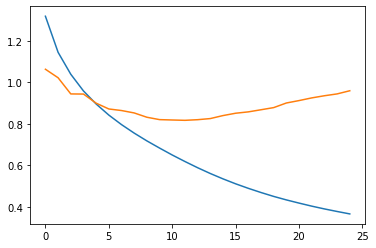

In [13]:
plt.plot(avg_training_losses)
plt.plot(avg_val_losses)

In [12]:
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': loss
}, 'resnet50baseline.pth')

In [14]:
y_true, y_predict = [], []

In [15]:
model.eval()
with torch.no_grad():
    for x, y in valloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x.float())
        predictions = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
        true = y.detach().cpu().numpy()
        y_predict.append(predictions)
        y_true.append(true)

In [16]:
count = 0
for a, b in zip(y_true, y_predict):
    for i, j in zip(a, b):
        if i == j:
            count += 1
print(f'Accuracy: {count/2552}')

Accuracy: 0.7460815047021944
